## Lab 10, Part 1:   Convolutional Neural Networks (CNN) 

In this lab, we will learn how to train CNNs. All the code is provided. The code is allowing you to prepare the data and train a CNN that classifies which digit is written in an image provided at its input. We will show how you can train 4 different CNN, ranging from simple to more complex, and let you observe how it impacts classification accuracy. 

### MNIST Data Set

MNIST is a dataset of hand-written digits. Size of each image is 28 by 28 pixels, where each pixel has values between 0 (white) and 255 (black). 

CNN training can take quite a bit of time (particularly if GPU isn't used), so we will create a training data set that uses a subset of available data. In particular, we will define the classification problem as recognizing whether a digit in an image is 7 or not. The following piece of code shows the data preparation steps.

In [1]:
#Import the required libraries
import numpy as np
#import tensorflow as tf
#from tensorflow.python.keras.layers import Input, Dense

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD

Using TensorFlow backend.


The following block selects a subset of images from the MNIST data.

In [17]:
#Load the training and testing data
(X_train, y_train), (X_test, y_test) = mnist.load_data()   
X_test_orig = X_test  #??

# Select the subset from the train data for the sake of time.
np.random.seed(1338)  # for reproducibilty!!             #??
# The subset is composed of all the examples where the digit is 7, and 20,000 examples are not 7.
sevens = np.where(y_train == 7)[0].tolist()
not_sevens = np.where(y_train != 7)[0].tolist()
num_keepers = 20000
not_sevens = np.random.choice(not_sevens, num_keepers, replace=False).tolist()

subset = sevens + not_sevens
np.random.shuffle(subset) # shuffle the input

X_train = X_train[subset, :, :]
y_train = y_train[subset]

The following code creates training and test data. It would be great if you can spend a few minutes trying to understand what is going on.

In [36]:
from keras import backend as K

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':  #??
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

# Normalize the images:

X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

# Create labels:

# Converting the labels to binary classification(Seven =1,Not Seven=0)
Y_train = (y_train == 7).astype(int)
Y_test = (y_test == 7).astype(int)

# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

**Question 1.** What are the dimensions of X_train, X_test, Y_train and Y_test? What are ranges of numbers in each of those?

In [70]:
***Question 1***
print ("The length of X_train is" ,len(X_train))
print ("The length of X_test is" ,len(X_test))
print ("The length of Y_train is" ,len(Y_train))
print ("The length of Y_test is" ,len(Y_test))
print ("The ranges of numbers in X_train is: (" , np.min(X_train),",",np.max(X_train),").")
print ("The ranges of numbers in X_test is: (" , np.min(X_test),",",np.max(X_test),").")
print ("The ranges of numbers in Y_train is: (" , np.min(Y_train),",",np.max(Y_train),").")
print ("The ranges of numbers in Y_test is: (" , np.min(Y_test),",",np.max(Y_test),").")

The length of X_train is 26265
The length of X_test is 10000
The length of Y_train is 26265
The length of Y_test is 10000
The ranges of numbers in X_train is: ( 0.0 , 0.003921569 ).
The ranges of numbers in X_test is: ( 0.0 , 0.003921569 ).
The ranges of numbers in Y_train is: ( 0.0 , 1.0 ).
The ranges of numbers in Y_test is: ( 0.0 , 1.0 ).


### Train a simple CNN (CNN, model 1)

The following code will show how you can define CNN, train it, and test its accuracy. 

**Step 0.** The following is a preparation step, specifying the hyperparameters.

In [4]:
# -- Initializing the values for the convolution neural network

nb_epoch = 2  # kept very low! Please increase if you have GPU

batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

**Step 1.** In this step we define architecture of the CNN

Each line "model.add()" adds another layer to the neural network. The type of layer must be specified. 

In [6]:
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(26, 26)))
model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
#https://keras.io/layers/convolutional/

We can check the configuration of the above model by call model.summary()

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


** Question 2. ** From the above summary, can you explain the architecture of this CNN?

In [ ]:
The CNN model has six layers:
1. The first layer is a 2D convolution layer. The layer has 32 feature maps, which with the size of 3×3 and a rectifier activation function. 
This is the input layer, expecting images with the structure outline above [pixels][width][height].
2. The second layer is an activation relu layer which makes the stack of images with no negative value
3. The third layer is a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 26×26.
4. The fourth layer is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
5. The fifth layer is a fully connected layer with 2 neurons.
6. The final layer is a softmax activation function used on the output layer to turn the outputs into probability-like values 
and allow one class of the 10 to be selected as the model’s output prediction. 

**Step 2.** Here, we define the loss function. You will see that the loss function is not Mean Square Error, but Cross Entropy. Cross Entropy is a very popular choice when training neural networks for classification problems.

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

**Step 3.** This line of code trains CNN. This is going to take about a minute. Observe that we will only have 2 epochs of training, in the iterest of time. You will see how the accuracy on training and valiadion data evolves during training.

In [9]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 20s 777us/step - loss: 0.3596 - acc: 0.8657 - val_loss: 0.6899 - val_acc: 0.6330
Epoch 2/2
26265/26265 [==============================] - 14s 536us/step - loss: 0.2399 - acc: 0.9148 - val_loss: 0.6186 - val_acc: 0.6942


Let us plot the accuracy. 

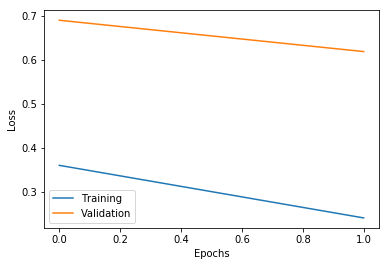

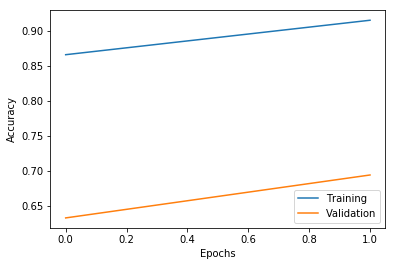

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

**Step 4.** Evaluate the accuracy on test data.

In [167]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

('Test Loss:', 0.5998013210296631)
('Test Accuracy:', 0.70369999999999999)


Let us visualize our model Predictions!

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

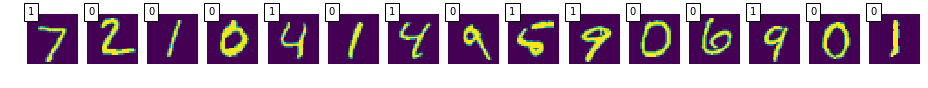

In [12]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

**Question 3.** Can you discuss the performance of the CNN model? What kind of errors is it making?

In [ ]:
The performance of the CNN model is not too good. When the epochs is too small, the model might be underfitting

**Question 4.** Run the training for 10 epochs. How did it impact the accuracy?

In [13]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=10, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/10
26265/26265 [==============================] - 52s 2ms/step - loss: 0.2138 - acc: 0.9236 - val_loss: 0.1074 - val_acc: 0.9651
Epoch 2/10
26265/26265 [==============================] - 14s 539us/step - loss: 0.2036 - acc: 0.9267 - val_loss: 0.3329 - val_acc: 0.8532
Epoch 3/10
26265/26265 [==============================] - 14s 543us/step - loss: 0.1917 - acc: 0.9318 - val_loss: 0.1141 - val_acc: 0.9610
Epoch 4/10
26265/26265 [==============================] - 14s 537us/step - loss: 0.1855 - acc: 0.9315 - val_loss: 0.0956 - val_acc: 0.9670
Epoch 5/10
26265/26265 [==============================] - 14s 548us/step - loss: 0.1788 - acc: 0.9360 - val_loss: 0.1229 - val_acc: 0.9578
Epoch 6/10
26265/26265 [==============================] - 14s 546us/step - loss: 0.1833 - acc: 0.9325 - val_loss: 0.1653 - val_acc: 0.9392
Epoch 7/10
26265/26265 [==============================] - 14s 545us/step - loss: 0.1780 - acc: 0.9351 - val_loss: 0.10

In [15]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.08802235399186611
Test Accuracy: 0.9707


In [ ]:
As we can see, the test accuracy increases.

### Train a more complicated CNN (CNN, model 2)

Now, we will define a more complicated CNN architecture.

In [17]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               692352    
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
__________

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 36s 1ms/step - loss: 0.1959 - acc: 0.9274 - val_loss: 0.0920 - val_acc: 0.9724
Epoch 2/2
26265/26265 [==============================] - 20s 771us/step - loss: 0.0921 - acc: 0.9694 - val_loss: 0.0630 - val_acc: 0.9804


In [20]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.06298401280529797
Test accuracy: 0.9804


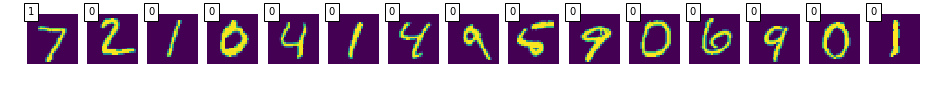

In [21]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

Wow! We have lifted the accuracy from 70.4% to 97.8%. This model can figure out the two "4"s  are not 7, but still be confused by pesky "9"! 

**Question 5.** Can you explain the architecture of this CNN (model 2) and how is it different from the first CNN you trained (model 1)? Compare their performance by looking at the visualizstions.

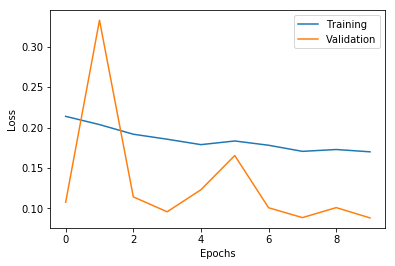

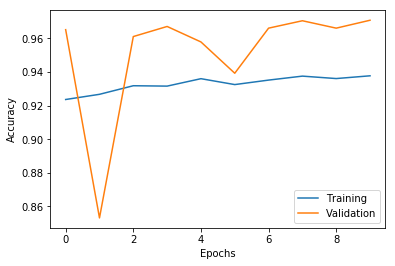

In [22]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

In [ ]:
This new model has more layers than the first one. Raw images get densed and relued more than once in this model
From the viz we can tell after epochs>2, the training and validation lines are closer to each other than what we see in model 1.
And the overall accuarcy is much higher.

### Adding more convolutional layers and MaxPooling layers (CNN, model 3)

Now, we will define an even more complicated CNN architecture.

In [23]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                 padding='valid'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1602      
__________

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 380s 14ms/step - loss: 0.2589 - acc: 0.8964 - val_loss: 0.1158 - val_acc: 0.9701
Epoch 2/2
26265/26265 [==============================] - 32s 1ms/step - loss: 0.1081 - acc: 0.9642 - val_loss: 0.0749 - val_acc: 0.9777


In [26]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.0749330561965704
Test accuracy: 0.9777


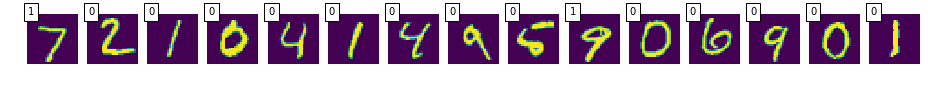

In [27]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

Another 0.2 % lift from 97.8% to 98.0%. This model sees clearly "9" is different than "7"! 

### Wrapping all the code together and play with hyperparameters

The code below wraps up the pieces of codes above into a single function and allows you to play with the hyperparameters by changing the arguments.


In [5]:
# Function for constructing the convolution neural network
# Feel free to add parameters, if you want

def build_model(num_conv = 1, conv_activation = "relu", num_dense = 1, dense_activation  = "relu", 
               dropout = True, max_pooling = True):
    """"""
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                     padding='valid',
                     input_shape=shape_ord))
    model.add(Activation(conv_activation))
    
    for i in range(num_conv-1):
        model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
        model.add(Activation(conv_activation))
        
    if max_pooling is True:
        model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
        
    if dropout is True:
        model.add(Dropout(0.25))
    
    model.add(Flatten())

    if dropout is True:
        model.add(Dropout(0.5))
    
    for i in range(num_dense-1):
        model.add(Dense(128))
        model.add(Activation(dense_activation))
        
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=nb_epoch,verbose=1,
              validation_data=(X_test, Y_test))
          

    #Evaluating the model on the test data    
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(num_conv , 'convolutional layers,', num_dense, "dense layers")
    if max_pooling: print("With max pooling")
    if dropout: print("With dropout")
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    slice = 15
    predicted = model.predict(X_test[:slice]).argmax(-1)

    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test_orig[i], interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

An example of running this function

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 33s 1ms/step - loss: 0.2214 - acc: 0.9190 - val_loss: 0.0956 - val_acc: 0.9750
Epoch 2/2
26265/26265 [==============================] - 29s 1ms/step - loss: 0.1253 - acc: 0.9563 - val_loss: 0.0759 - val_acc: 0.9782
1 convolutional layers, 1 dense layers
With max pooling
With dropout
Test score: 0.0758722451530397
Test accuracy: 0.9782


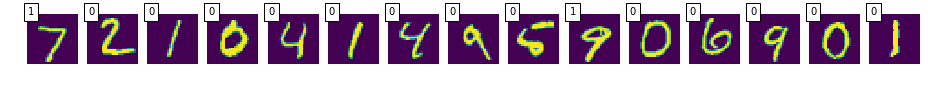

In [30]:
# Here is an example of running build_model() with default hyperparameters
build_model()

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 72s 3ms/step - loss: 0.2559 - acc: 0.8909 - val_loss: 0.0780 - val_acc: 0.9745
Epoch 2/2
26265/26265 [==============================] - 62s 2ms/step - loss: 0.1125 - acc: 0.9597 - val_loss: 0.0690 - val_acc: 0.9776
3 convolutional layers, 3 dense layers
With max pooling
With dropout
Test score: 0.06897599515933543
Test accuracy: 0.9776


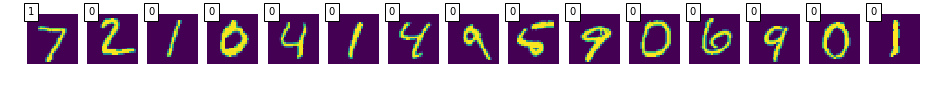

In [31]:
# Here is an example of running build_model() with new hyperparameters
build_model(num_conv = 3, num_dense = 3)

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 29s 1ms/step - loss: 0.2290 - acc: 0.9151 - val_loss: 0.0894 - val_acc: 0.9779
Epoch 2/2
26265/26265 [==============================] - 30s 1ms/step - loss: 0.1259 - acc: 0.9570 - val_loss: 0.0764 - val_acc: 0.9785
1 convolutional layers, 1 dense layers
With max pooling
With dropout
Test score: 0.07637123756185174
Test accuracy: 0.9785
1min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


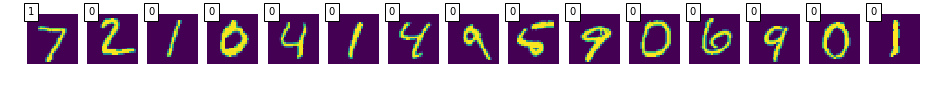

In [32]:
#Timing how long it takes to build the model and test it.
%timeit -n1 -r1 build_model()

**Question 6.** Try to change some of the **hyperparameters** without exploding the computational resources on your computer. 
What is the best accuracy you can get? How many parameters are there of each model? How long does the training take? Maybe increase the amount of data used? What does that do to the accuracy and training time? 

In [9]:
#Here are some of the hyperparameters we set up previously, including the two values we can call within the function. 
#Thus there are about 10 hyperparameteres we can change
#I believe the higher epochs I use, the higher accuacry I can get but it will take a lot of time. The highest accuracy I get for now
is 98.62%

nb_epoch = 5  # kept very low! Please increase if you have GPU

batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

Train on 26265 samples, validate on 10000 samples
Epoch 1/5
26265/26265 [==============================] - 73s 3ms/step - loss: 0.3117 - acc: 0.8633 - val_loss: 0.0708 - val_acc: 0.9782
Epoch 2/5
26265/26265 [==============================] - 71s 3ms/step - loss: 0.1141 - acc: 0.9598 - val_loss: 0.0572 - val_acc: 0.9827
Epoch 3/5
26265/26265 [==============================] - 68s 3ms/step - loss: 0.0936 - acc: 0.9677 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 4/5
26265/26265 [==============================] - 67s 3ms/step - loss: 0.0810 - acc: 0.9732 - val_loss: 0.0483 - val_acc: 0.9849
Epoch 5/5
26265/26265 [==============================] - 63s 2ms/step - loss: 0.0722 - acc: 0.9764 - val_loss: 0.0447 - val_acc: 0.9857
3 convolutional layers, 3 dense layers
With max pooling
With dropout
Test score: 0.044686897536553444
Test accuracy: 0.9857


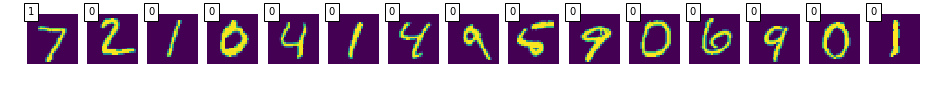

In [10]:
build_model(num_conv = 3, num_dense = 3)

Train on 26265 samples, validate on 10000 samples
Epoch 1/5
26265/26265 [==============================] - 75s 3ms/step - loss: 0.2852 - acc: 0.8802 - val_loss: 0.0721 - val_acc: 0.9766
Epoch 2/5
26265/26265 [==============================] - 66s 3ms/step - loss: 0.1126 - acc: 0.9591 - val_loss: 0.0638 - val_acc: 0.9797
Epoch 3/5
26265/26265 [==============================] - 67s 3ms/step - loss: 0.0967 - acc: 0.9665 - val_loss: 0.0572 - val_acc: 0.9815
Epoch 4/5
26265/26265 [==============================] - 71s 3ms/step - loss: 0.0828 - acc: 0.9720 - val_loss: 0.0458 - val_acc: 0.9860
Epoch 5/5
26265/26265 [==============================] - 70s 3ms/step - loss: 0.0739 - acc: 0.9749 - val_loss: 0.0431 - val_acc: 0.9862
3 convolutional layers, 3 dense layers
With max pooling
With dropout
Test score: 0.04305080297803506
Test accuracy: 0.9862
5min 58s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


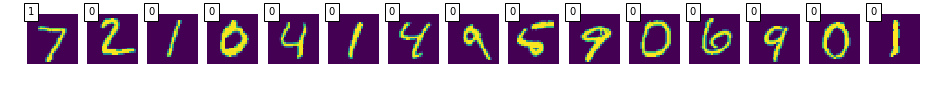

In [11]:
#Timing how long it takes to build the model and test it.
%timeit -n1 -r1 build_model(num_conv = 3, num_dense = 3)

In [ ]:
Increase the amount of the data used can increase accuarcy but increase the tranining time as well.

#### Question 7 (20% of the grade)

Can you train a model to output 10 classes instead of 2 binary classes? We can use this model to classify images into 10 digits of the mnist data set. Again, we will only train our model on a subset of the training data. The following steps will help you to build such a model.

    * 1. Select 20,000 examples randomly from X_train, since we want all 10 digits present in our training data.
    * 2. Convert Y_train and Y_test to categorical.
    * 3. Call the build_model() on the X_train and Y_train.

In [87]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test_orig = X_test
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
X_train, w_test, y_train, v_test = train_test_split(X_train, y_train, test_size=0.66)
print("X_train is:", X_train.shape)

X_train is: (20400, 28, 28)


In [88]:
from keras import backend as K

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':  
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

# Normalize the images:

X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

# Converting the classes to its binary categorical form
nb_classes = 10
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [95]:
import matplotlib.pyplot as plt

%matplotlib inline

nb_epoch = 10  # kept very low! Please increase if you have GPU

batch_size = 128
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

In [96]:
def build_model(num_conv = 1, conv_activation = "relu", num_dense = 1, dense_activation  = "relu", 
               dropout = True, max_pooling = True):
    """"""
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                     padding='valid',
                     input_shape=shape_ord))
    model.add(Activation(conv_activation))
    
    for i in range(num_conv-1):
        model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
        model.add(Activation(conv_activation))
        
    if max_pooling is True:
        model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
        
    if dropout is True:
        model.add(Dropout(0.25))
    
    model.add(Flatten())

    if dropout is True:
        model.add(Dropout(0.5))
    
    for i in range(num_dense-1):
        model.add(Dense(128))
        model.add(Activation(dense_activation))
        
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(X_train, y_train, batch_size=batch_size, 
              epochs=nb_epoch,verbose=1,
              validation_data=(X_test, y_test))
          

    #Evaluating the model on the test data    
    score, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(num_conv , 'convolutional layers,', num_dense, "dense layers")
    if max_pooling: print("With max pooling")
    if dropout: print("With dropout")
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    slice = 15
    predicted = model.predict(X_test[:slice]).argmax(-1)

    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test_orig[i], interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

Train on 20400 samples, validate on 10000 samples
Epoch 1/2
20400/20400 [==============================] - 111s 5ms/step - loss: 2.0771 - acc: 0.3824 - val_loss: 1.5309 - val_acc: 0.7871
Epoch 2/2
20400/20400 [==============================] - 46s 2ms/step - loss: 1.0629 - acc: 0.7328 - val_loss: 0.6353 - val_acc: 0.8494
1 convolutional layers, 1 dense layers
With max pooling
With dropout
Test score: 0.6353186000347137
Test accuracy: 0.8494


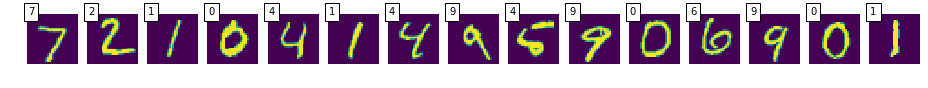

In [91]:
build_model()

Train on 20400 samples, validate on 10000 samples
Epoch 1/2
20400/20400 [==============================] - 97s 5ms/step - loss: 2.2650 - acc: 0.1628 - val_loss: 2.0717 - val_acc: 0.3452
Epoch 2/2
20400/20400 [==============================] - 80s 4ms/step - loss: 1.2695 - acc: 0.5815 - val_loss: 0.4808 - val_acc: 0.8559
3 convolutional layers, 3 dense layers
With max pooling
With dropout
Test score: 0.4808335528612137
Test accuracy: 0.8559


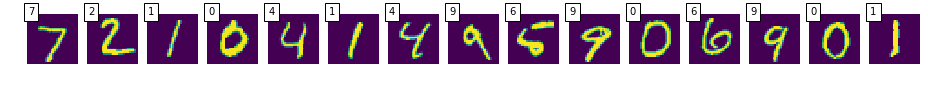

In [94]:
build_model(num_conv = 3, num_dense = 3)

Train on 20400 samples, validate on 10000 samples
Epoch 1/10
20400/20400 [==============================] - 99s 5ms/step - loss: 2.2896 - acc: 0.1563 - val_loss: 2.2530 - val_acc: 0.3307
Epoch 2/10
20400/20400 [==============================] - 82s 4ms/step - loss: 1.8721 - acc: 0.3962 - val_loss: 0.6401 - val_acc: 0.8139
Epoch 3/10
20400/20400 [==============================] - 82s 4ms/step - loss: 0.7499 - acc: 0.7547 - val_loss: 0.5246 - val_acc: 0.8353
Epoch 4/10
20400/20400 [==============================] - 80s 4ms/step - loss: 0.5665 - acc: 0.8211 - val_loss: 0.3680 - val_acc: 0.8865
Epoch 5/10
20400/20400 [==============================] - 79s 4ms/step - loss: 0.4805 - acc: 0.8514 - val_loss: 0.3190 - val_acc: 0.8990
Epoch 6/10
20400/20400 [==============================] - 73s 4ms/step - loss: 0.4318 - acc: 0.8678 - val_loss: 0.2756 - val_acc: 0.9139
Epoch 7/10
20400/20400 [==============================] - 62s 3ms/step - loss: 0.3806 - acc: 0.8843 - val_loss: 0.2499 - val_acc

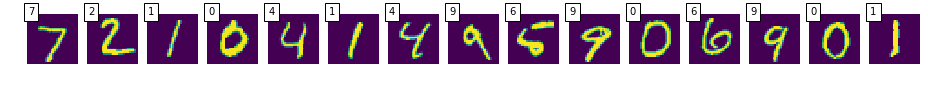

In [97]:
build_model(num_conv = 3, num_dense = 3) #This one I changed epochs to 10